<a href="https://colab.research.google.com/github/MissUnique/MEDVSE-Project/blob/main/Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries

In [9]:
from cProfile import label

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data Overview


The MTHS dataset was collected to provide PPG signals using a smartphone camera, as few such datasets exist. Key details:

- **Device used**: iPhone 5s (30 fps), with flashlight on.

- **Participants**: 62 total (35 men, 27 women).

- **Sampling**:
    - PPG signal: 30 Hz.
    - Ground truth (Heart Rate & SpO₂): 1 Hz, measured using a pulse oximeter (M70).
    
- **Procedure**: Patients fully covered the camera and flashlight with their fingertips.

# Data Pre-Processing

Data pre-processing is a crucial step that enhances data quality and reliability, providing valuable insights into its structure, patterns, and any inconsistencies. This stage helps identify and handle missing or noisy data, normalize values, and prepare the dataset for analysis or modeling. Effective pre-processing enables us to make informed decisions about further steps, ensuring that the dataset is accurate, consistent, and ready for optimal performance in subsequent analysis or machine learning tasks.

**in this section :**

1- Create a Metadata DataFrame

2- Visualize Sample Data


In [10]:
# Create Dictionary
# Number of labels refers to the number of samples extracted from each signal.
Dic = {"patient_ID" : [],"Gender" : [],"number_of_labels" : []}
root_path = "/content/MEDVSE"
patients_metadata = pd.read_excel("MEDVSE/MTHS/gender.xlsx")
time_length = 10

for i in range(67):
    try:
        signals = np.load(f"{root_path}/MTHS/Data/signal_{i}.npy")
        labels = np.load(f"{root_path}/MTHS/Data/label_{i}.npy")

        Dic["patient_ID"].append(i)
        Dic["Gender"].append(patients_metadata[patients_metadata["id"] == i]["gender"].values[0])
        Dic["number_of_labels"].append(labels.shape[0]/time_length)
    except:
        continue

# Meta Data
data = pd.DataFrame.from_dict(Dic)

In [11]:
data.head(5)

,patient_ID,Gender,number_of_labels
0,2,M,2.6
1,3,F,5.9
2,4,M,7.9
3,5,F,6.0
4,6,M,6.4


## Visualization

In [12]:
def visualize(i):
    assert 2 <= i <= 66, "out of bounds"
    signals = np.load(f"{root_path}/MTHS/Data/signal_{i}.npy")
    plt.plot(list(range(signals.shape[0])),signals[:,0])

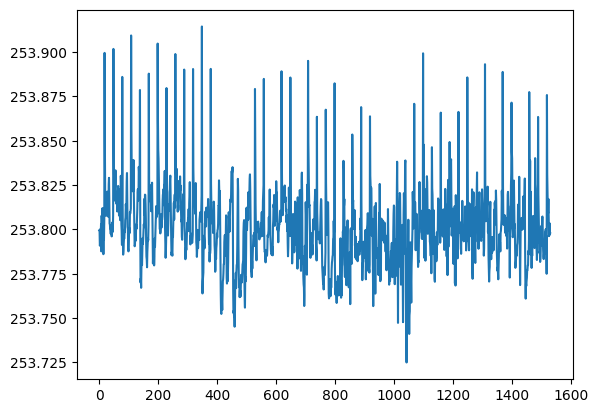

In [13]:
visualize(8)

From different experiments, it has been found that normalizing the values is essential. Larger values can disproportionately affect the models’ performance, as it may interpret them as more important. Therefore, normalizing the data ensures that all features contribute equally to the model

<Axes: xlabel='Gender'>

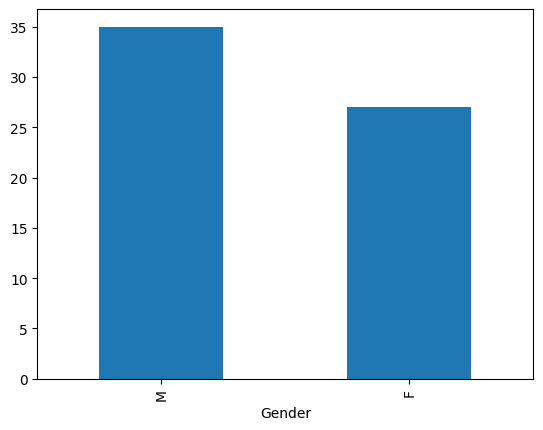

In [14]:
data["Gender"].value_counts().plot.bar()

From the plot, we can see that the gap between females and males is not very large. Since it is important to split the data such that the distribution of patients is consistent across the sets, this should be taken into account.

# Important Takeaways from the Paper

There are several important points to note from the paper:

**Missing Technical Details:** Many technical details are missing in the paper, which led me to consult the code to check the values. However, this was the extent of the information available.

**Methodologies:**
- **Gender distribution:** The author did not ensure that gender was evenly distributed across the three sets. The distribution of gender can significantly impact the model's performance and generalizability.

- **Data Splitting Methodology:** The author splits the data by combining all the values in the signal into one vector and then processes the data into sequences. Afterward, the data is split randomly. I believe this approach is flawed and may lead to data leakage.

**Reason:**
In medical applications, it is better to split the data by patient (depending on the case). In this scenario, each patient’s data should be assigned to either the training, validation, or testing set, with no overlap between them. This is critical because if the same patient’s data appears in multiple sets, it could result in unintended patterns or rhythms being shared across the training, validation, and testing sets, leading to data leakage and inflated results.

As part of my work, I believe it is essential to investigate the methodologies presented in papers and validate their correctness before basing my work on potentially flawed studies. While the task at hand is to replicate the paper and obtain similar results, I will proceed with the data splitting method I believe is more appropriate. However, I will retain the models created by the authors without any adjustments.



## Data Splitting

In this section,
- I will split the data such that each patient's data is assigned to only one section (either training, validation, or testing).

- I will use a standard practice for data distribution (70% training, 15% validation, and 15% testing) as the proposed 80%, 4%, and 16% distribution in the paper provides insufficient validation data for this small dataset. That way, the model's performance is not assessed properly.

- I will ensure that gender is equally distributed across the three sets.

In [18]:
total_labels = data['number_of_labels'].sum()

train_size = int(total_labels * 0.7)
val_size = int(total_labels * 0.15)
test_size = total_labels - train_size - val_size

# Shuffle the data randomly (to ensure randomness in patient assignment)
data_shuffled = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Assign patients to the sets based on cumulative labels
train_data = []
val_data = []
test_data = []

cumulative_labels = 0

# assign to training set first
for index, row in data_shuffled.iterrows():
    cumulative_labels += row['number_of_labels']
    if cumulative_labels <= train_size:
        train_data.append(row)
    elif cumulative_labels <= train_size + val_size:
        val_data.append(row)
    else:
        test_data.append(row)

# Convert back to DataFrames
train_data = pd.DataFrame(train_data)
val_data = pd.DataFrame(val_data)
test_data = pd.DataFrame(test_data)

# Print the results to verify
print("Training Data:")
print(train_data)
print("\nValidation Data:")
print(val_data)
print("\nTest Data:")
print(test_data)

# Optionally, save the splits to CSV
train_data.to_csv('train_data.csv', index=False)
val_data.to_csv('val_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)


Training Data:
    patient_ID Gender  number_of_labels
0           55      M               6.0
1           61      F               6.2
2            2      M               2.6
3           62      F               6.0
4            7      M               6.1
5           53      F               6.0
6           21      M              11.9
7           14      M              11.9
8           30      M              11.9
9           64      F               6.2
10          35      M               6.0
11          11      F               5.9
12          52      F               6.0
13          15      M               6.1
14          38      F               6.0
15          39      F               6.0
16           5      F               6.0
17          22      M              12.2
18          59      F               6.0
19          10      M               6.0
20           8      M               5.1
21          36      M               6.0
22           6      M               6.4
23          50      F    

In [20]:
train_patients = set(train_data['patient_ID'])
val_patients = set(val_data['patient_ID'])
test_patients = set(test_data['patient_ID'])

# To make sure that there is no overlap across the sets
train_val_overlap = train_patients.intersection(val_patients)
train_test_overlap = train_patients.intersection(test_patients)
val_test_overlap = val_patients.intersection(test_patients)

# Print the results of the overlap check
print("Overlap Checks:")
print(f"Overlap between training and validation sets: {train_val_overlap}")
print(f"Overlap between training and test sets: {train_test_overlap}")
print(f"Overlap between validation and test sets: {val_test_overlap}")

Overlap Checks:
Overlap between training and validation sets: set()
Overlap between training and test sets: set()
Overlap between validation and test sets: set()


<Axes: xlabel='Gender'>

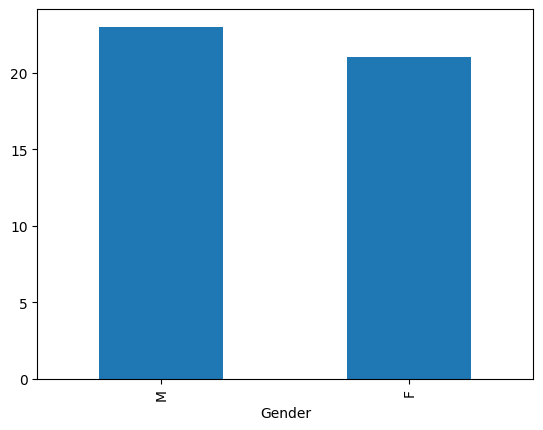

In [21]:
train_data["Gender"].value_counts().plot.bar()

<Axes: xlabel='Gender'>

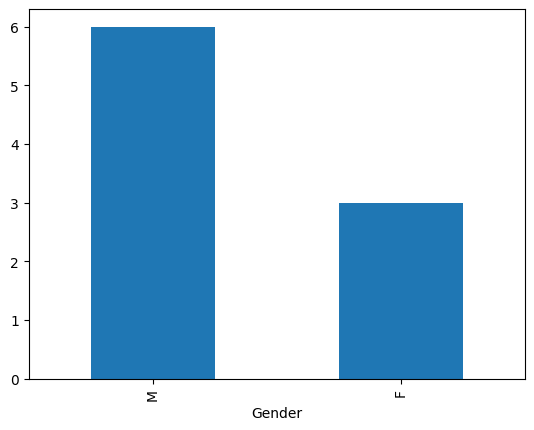

In [22]:
val_data["Gender"].value_counts().plot.bar()

<Axes: xlabel='Gender'>

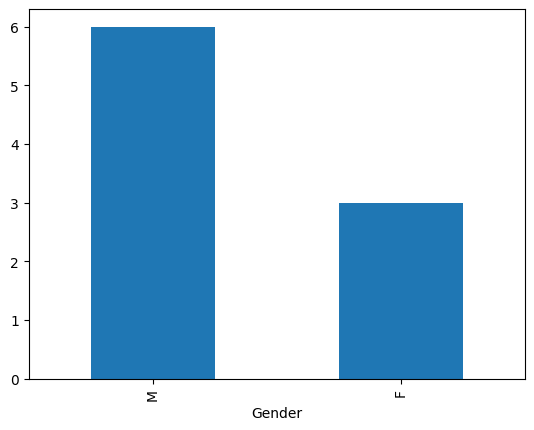

In [23]:
test_data["Gender"].value_counts().plot.bar()

The gender distribution in the training set is balanced, which is beneficial for the model’s generalization. Additionally, the gender distribution is equal in both the testing and validation sets, as they reflect real-world conditions. Therefore, the data split is appropriate.

# Data Loader

In [28]:
from models_dataloaders import *

train_csv = "train_data.csv"
val_csv = "val_data.csv"
test_csv = "test_data.csv"
root_path = "/content/MEDVSE"
dwn_factor = 2
time_length = 10
mode = "hr"  # Choose "hr" or "spo2" based on mode
batch_size = 32

# Create training dataset and fit signal scaler for signals
train_dataset = SignalDataset(train_csv, root_path, dwn_factor, time_length, mode)
signal_scaler = fit_scaler_on_train_data(train_dataset, mode)  # Pass the mode

# Fit the label scaler based on the mode (hr or spo2)
label_scaler = fit_label_scaler_on_train_data(train_dataset, mode)

# Create datasets with the fitted scalers for train, validation, and test
train_dataset = SignalDataset(train_csv, root_path, dwn_factor, time_length, mode, signal_scaler, label_scaler)
val_dataset = SignalDataset(val_csv, root_path, dwn_factor, time_length, mode, signal_scaler, label_scaler)
test_dataset = SignalDataset(test_csv, root_path, dwn_factor, time_length, mode, signal_scaler, label_scaler)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#
for ppg, label in train_loader:
    print("PPG batch shape:", ppg.shape)  # Should be [batch_size, seq_len, 3]
    print("Label batch shape:", label.shape)  # Should be [batch_size]
    break


PPG batch shape: torch.Size([32, 150, 3])
Label batch shape: torch.Size([32])


In [29]:
# Check one Sample
A, B = next(iter(train_loader))
print(A, B)

# Check the data length
print(f"\nData Length is {len(train_dataset)}")

tensor([[[ 0.7471,  0.7471,  0.7471],
         [ 0.7251,  0.7251,  0.7251],
         [ 0.7319,  0.7319,  0.7319],
         ...,
         [ 0.7258,  0.7258,  0.7258],
         [ 0.7245,  0.7245,  0.7245],
         [ 0.7318,  0.7318,  0.7318]],

        [[ 0.4347,  0.4347,  0.4347],
         [ 0.4662,  0.4662,  0.4662],
         [ 0.4940,  0.4940,  0.4940],
         ...,
         [ 0.2862,  0.2862,  0.2862],
         [ 0.1450,  0.1450,  0.1450],
         [ 0.0910,  0.0910,  0.0910]],

        [[ 0.4629,  0.4629,  0.4629],
         [ 0.4975,  0.4975,  0.4975],
         [ 0.5204,  0.5204,  0.5204],
         ...,
         [-0.0034, -0.0034, -0.0034],
         [ 0.0103,  0.0103,  0.0103],
         [ 0.0436,  0.0436,  0.0436]],

        ...,

        [[ 0.6670,  0.6670,  0.6670],
         [ 0.6687,  0.6687,  0.6687],
         [ 0.6688,  0.6688,  0.6688],
         ...,
         [ 0.6950,  0.6950,  0.6950],
         [ 0.6958,  0.6958,  0.6958],
         [ 0.6968,  0.6968,  0.6968]],

        [[